# Vehicle Detection

The pipeline of vehicle detection contains the following steps: 

* Extract the features: Histogram of Oriented Gradients (HOG), color features (spatial and histograms). 
* Normalize and randomize the dataset. 
* Train a Linear SVM classifier. 
* Implement a sliding-window method and use SVM classifier to identify the vehicles in the figure.
* Create a heat map to reject the outliers. 
* Apply the steps above in the video stream and follow the vehicles. 

### Imports

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.externals import joblib
from skimage.feature import hog
from scipy.ndimage.measurements import label
import glob
import time
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Feature Extraction

In [2]:
# a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=False, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32, bins_range=(0, 1)): # (0,1) for png file. 
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [3]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 650] # Min and max in y to search in slide_window()


### Collect Data  Features

In [4]:
cars = glob.glob('./train_data/vehicles/*/*.png')
notcars = glob.glob('./train_data/non-vehicles/*/*.png')

In [5]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


### Train the SVM Classifier

In [6]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 9636
4.75 Seconds to train SVC...
Test Accuracy of SVC =  0.993


### Load the saved model

In [4]:
svc, X_scaler = joblib.load('svc-model.pkl')

### Window sliding

In [5]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    x_step_px = np.int(xy_window[0]*(1 - xy_overlap[0]))
    y_step_px = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx = int((x_span-int(xy_window[0]*xy_overlap[0]))/x_step_px)
    ny = int((y_span-int(xy_window[1]*xy_overlap[1]))/y_step_px)
    # Initialize a list to append window positions to
    window_list = []
    for ys in range(ny):
        for xs in range(nx):
            # Calculate window position
            startx = xs*x_step_px + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*y_step_px + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows



### Multi-size Window Sliding

In [6]:
image = mpimg.imread('./test_images/test_image1.jpg')

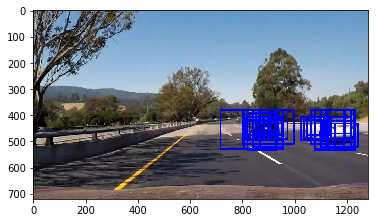

In [7]:
winsow_sizes = (70, 90, 110, 130, 150)
def multi_window_search(image, winsow_sizes, svc, X_scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=11, 
                    pix_per_cell=11, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    hot_windows=[]
    for i in range(len(winsow_sizes)):
        xy_window = (winsow_sizes[i], winsow_sizes[i])
        y_start = 380
        y_stop = 490+40*i
        x_start = 606-i*130
        overlap = 0.8 - 0.1*i
        y_start_stop = [y_start, y_stop]
        windows = slide_window(image, x_start_stop=[x_start, None], y_start_stop=y_start_stop, 
                            xy_window=xy_window, xy_overlap=(overlap, overlap))
        hot_window = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)        
        hot_windows.extend(hot_window)
    return hot_windows

hot_windows = multi_window_search(image.astype(np.float32)/255, winsow_sizes, svc, X_scaler, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)   

draw_image = np.copy(image)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

### Heatmap

In [14]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        x_size = np.max(nonzerox)-np.min(nonzerox)
        aspect_ratio = (np.max(nonzerox)-np.min(nonzerox))/(np.max(nonzeroy)-np.min(nonzeroy))
        if (aspect_ratio>0.2) & (aspect_ratio<5) & (x_size>65):
        # Find out the real car based on the aspect ratio and size
        # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


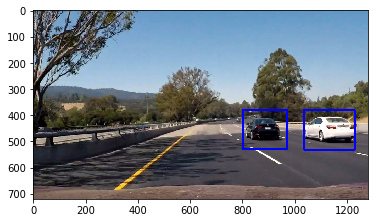

In [10]:
# Test heatmap 
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat, hot_windows)
heat = apply_threshold(heat, 1)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
plt.imshow(draw_img)

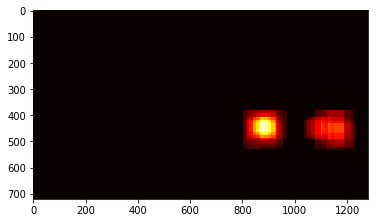

In [11]:
plt.imshow(heatmap, cmap='hot')

### Pipeline of video processing

In [12]:
hot_cache=[]
frame_num=0
cache_num = 4
def img_proc(image):
    global hot_cache
    global frame_num
    if frame_num > cache_num:
        hot_windows = multi_window_search(image.astype(np.float32)/255, winsow_sizes, svc, X_scaler, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)  
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        heat = add_heat(heat, hot_windows)
        hot_cache.append(heat)
        hot_cache = hot_cache[-cache_num:]
        heat_best = np.average(hot_cache, axis=0)
        heat = apply_threshold(heat_best, 1)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        frame_num += 1
    else: 
        hot_windows = multi_window_search(image.astype(np.float32)/255, winsow_sizes, svc, X_scaler, color_space=color_space,
                    spatial_size=spatial_size, hist_bins=hist_bins,
                    orient=orient, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block,
                    hog_channel=hog_channel, spatial_feat=spatial_feat,
                    hist_feat=hist_feat, hog_feat=hog_feat)  
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        heat = add_heat(heat, hot_windows)
        hot_cache.append(heat)
        heat = apply_threshold(heat, 1)
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        frame_num += 1
    return draw_img

In [14]:
hot_cache=[]
frame_num=0
output_clip = 'vehicle_detection_test.mp4'
clip2 = VideoFileClip("test_video.mp4")
vehicle_detect = clip2.fl_image(img_proc)
%time vehicle_detect.write_videofile(output_clip, audio=False)

[MoviePy] >>>> Building video vehicle_detection_test.mp4
[MoviePy] Writing video vehicle_detection_test.mp4


 97%|█████████▋| 38/39 [01:00<00:01,  1.60s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle_detection_test.mp4 

CPU times: user 1min, sys: 63.6 ms, total: 1min
Wall time: 1min 1s


In [15]:
hot_cache=[]
frame_num=0
output_clip = 'project_video_output.mp4'
clip2 = VideoFileClip("project_video.mp4")
vehicle_detect = clip2.fl_image(img_proc)
%time vehicle_detect.write_videofile(output_clip, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [26:18<00:01,  1.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 26min 5s, sys: 11.1 s, total: 26min 16s
Wall time: 26min 18s
